In [53]:
import pandas as pd
import jax.numpy as jnp
import numpy as np
import evofr as ef
import matplotlib.pyplot as plt

In [54]:
# Getting data for analysis from #ncov-escape
PANGO_VARIANT_SEQUENCE_COUNTS_URL = "https://raw.githubusercontent.com/blab/ncov-escape/master/mlr-fitness/data/pango_seq_counts.tsv"
PANGO_VARIANT_RELATIONSHIPS_URL = "https://raw.githubusercontent.com/blab/ncov-escape/master/mlr-fitness/data/pango_variant_relationships.tsv"

# Loading data into pandas√Ω
raw_seq = pd.read_csv(PANGO_VARIANT_SEQUENCE_COUNTS_URL, sep="\t")
raw_variant_parents = pd.read_csv(PANGO_VARIANT_RELATIONSHIPS_URL, sep="\t")
raw_variant_parents = pd.concat((raw_variant_parents, pd.DataFrame({"variant": ["BA.2"], "parent": ["base"]}))).reset_index(drop=True)

In [55]:
raw_variant_parents

,variant,parent
0,B.1,BA.2
1,B.1.1.529,B.1
2,BA.1,BA.2
3,BA.1.1,BA.1
4,BA.1.1.1,BA.1.1
...,...,...
351,XBE,BA.2
352,XBF,BA.2
353,XE,BA.2
354,XZ,BA.2


In [56]:
variant_freqs = ef.InnovationSequenceCounts(raw_seq, raw_variant_parents, pivot="BA.2")
variant_freqs.var_names

['B.1',
 'B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.1.1.1',
 'BA.1.1.10',
 'BA.1.1.14',
 'BA.1.1.16',
 'BA.1.1.18',
 'BA.1.1.2',
 'BA.1.15',
 'BA.1.15.2',
 'BA.1.17.2',
 'BA.1.18',
 'BA.1.20',
 'BA.2.1',
 'BA.2.10',
 'BA.2.10.1',
 'BA.2.12',
 'BA.2.12.1',
 'BA.2.13',
 'BA.2.13.1',
 'BA.2.18',
 'BA.2.20',
 'BA.2.21',
 'BA.2.22',
 'BA.2.23',
 'BA.2.23.1',
 'BA.2.26',
 'BA.2.3',
 'BA.2.3.10',
 'BA.2.3.14',
 'BA.2.3.17',
 'BA.2.3.2',
 'BA.2.3.20',
 'BA.2.3.4',
 'BA.2.3.6',
 'BA.2.31',
 'BA.2.32',
 'BA.2.36',
 'BA.2.37',
 'BA.2.38',
 'BA.2.40.1',
 'BA.2.41',
 'BA.2.47',
 'BA.2.48',
 'BA.2.5',
 'BA.2.52',
 'BA.2.56',
 'BA.2.59',
 'BA.2.6',
 'BA.2.65',
 'BA.2.7',
 'BA.2.72',
 'BA.2.73',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.2.75.3',
 'BA.2.75.5',
 'BA.2.76',
 'BA.2.8',
 'BA.2.9',
 'BA.2.9.2',
 'BA.2.9.3',
 'BA.2.9.7',
 'BA.4',
 'BA.4.1',
 'BA.4.1.1',
 'BA.4.1.6',
 'BA.4.1.8',
 'BA.4.1.9',
 'BA.4.2',
 'BA.4.3',
 'BA.4.4',
 'BA.4.6',
 'BA.4.6.2',
 'BA.4.6.5',
 'BA.5',
 'BA.5.1',
 'BA.5.1.1',


In [57]:
variant_freqs.parent_map # What should we use for deltas against base?
variant_freqs.var_names.index("BA.2")

def get_parent_constrasts(variant_freqs):
    # Get indices
    
    var_names = variant_freqs.var_names
    child_names = [k for k,v in variant_freqs.parent_map.items() if v in var_names]

    index_pairs = [(var_names.index(k), var_names.index(v)) for k,v in variant_freqs.parent_map.items() if v in var_names]

    return index_pairs, child_names

In [58]:
escape_scores = pd.read_csv("../../ncov-escape/predictors/predictors.tsv", sep="\t")

def prep_escape_scores(escape_scores, variant_freqs):
    # Index by variant name
    escape_scores = escape_scores.rename(columns={"seqName": "variant"}).set_index("variant")
    escape_scores = (escape_scores[["immune_escape", "ace2_binding"]]
                     .replace("?")
                     .astype({"immune_escape":"float", "ace2_binding": "float"}))
    
    # Find scores of interest and parents
    var_names = [v for v in variant_freqs.var_names if v in escape_scores.index]
    escape_scores = escape_scores.loc[var_names] # Need all variants to be present...
    escape_scores["parent"] = escape_scores.index.map(variant_freqs.parent_map)
    
    # Get delta between parents and children
    def get_parent_delta(x, col="immune_escape"):
        variant = x.name
        parent = x.parent
        # If parent and child are present generate contrast
        if parent in escape_scores.index:
            return escape_scores.loc[variant][col] - escape_scores.loc[parent][col]
        # Gotta figure out how to deal with the nans
        return np.nan

    # Generate delta columns
    escape_scores["delta_immune_escape"] = escape_scores.apply(lambda x: get_parent_delta(x, "immune_escape"), axis=1)
    escape_scores["delta_ace2_binding"] = escape_scores.apply(lambda x: get_parent_delta(x, "ace2_binding"), axis=1)
    return escape_scores

escape_scores = prep_escape_scores(escape_scores, variant_freqs)
escape_scores

,immune_escape,ace2_binding,parent,delta_immune_escape,delta_ace2_binding
variant,,,,,
B.1,-0.000090,-0.00000,BA.2,-0.000090,-0.00000
BA.1,-0.000090,-0.00000,BA.2,-0.000090,-0.00000
BA.2.1,-0.000090,-0.00000,BA.2,-0.000090,-0.00000
BA.2.10,-0.000090,-0.00000,BA.2,-0.000090,-0.00000
BA.2.10.1,-0.000090,-0.00000,BA.2.10,0.000000,0.00000
...,...,...,...,...,...
XBE,0.601423,0.66973,BA.2,0.601423,0.66973
XBF,0.836642,1.04277,BA.2,0.836642,1.04277
XE,-0.000090,-0.00000,BA.2,-0.000090,-0.00000


In [59]:
predictors = pd.read_csv("../../ncov-escape/predictors/predictors.tsv", sep="\t")
predictor_names = ["immune_escape", "ace2_binding", "rbd_count", "non_rbd_spike_count", "non_spike_count"]
#delta_predictor_names = ["delta_" + name for name in predictor_names]

def prep_predictors(predictors, variant_freqs, predictor_names):
    # Index by variant name
    predictors = predictors.rename(columns={"seqName": "variant"}).set_index("variant")
    predictors = (predictors
                     .replace("?")
                     .astype({name: "float" for name in predictor_names}))
    
    # Find scores of interest and parents
    var_names = [v for v in variant_freqs.var_names if v in predictors.index]
    predictors = predictors.loc[var_names] # Need all variants to be present...
    predictors["parent"] = predictors.index.map(variant_freqs.parent_map)
    
    # Get delta between parents and children
    def get_parent_delta(x, col="immune_escape"):
        variant = x.name
        parent = x.parent
        # If parent and child are present generate contrast
        if parent in predictors.index:
            return predictors.loc[variant][col] - predictors.loc[parent][col]
        # Gotta figure out how to deal with the nans
        return np.nan

    # Generate delta columns
    for name in predictor_names:
        predictors[f"delta_{name}"] = predictors.apply(lambda x: get_parent_delta(x, name), axis=1)        
    return predictors

predictors = prep_predictors(predictors, variant_freqs, predictor_names)
predictors

,clade,Nextclade_pango,partiallyAliased,immune_escape,ace2_binding,rbd_count,non_rbd_spike_count,non_spike_count,parent,delta_immune_escape,delta_ace2_binding,delta_rbd_count,delta_non_rbd_spike_count,delta_non_spike_count
variant,,,,,,,,,,,,,,
B.1,outgroup,BA.2.19,BA.2.19,-0.000090,-0.00000,17.0,23.0,29.0,BA.2,-0.000090,-0.00000,17.0,23.0,29.0
BA.1,outgroup,BA.2.19,BA.2.19,-0.000090,-0.00000,6.0,19.0,18.0,BA.2,-0.000090,-0.00000,6.0,19.0,18.0
BA.2.1,21L,BA.2.1,BA.2.1,-0.000090,-0.00000,0.0,0.0,2.0,BA.2,-0.000090,-0.00000,0.0,0.0,2.0
BA.2.10,21L,BA.2.10,BA.2.10,-0.000090,-0.00000,0.0,0.0,2.0,BA.2,-0.000090,-0.00000,0.0,0.0,2.0
BA.2.10.1,21L,BA.2.10.1,BA.2.10.1,-0.000090,-0.00000,0.0,1.0,2.0,BA.2.10,0.000000,0.00000,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XBE,recombinant,XBE,XBE,0.601423,0.66973,4.0,2.0,4.0,BA.2,0.601423,0.66973,4.0,2.0,4.0
XBF,recombinant,XBF,XBF,0.836642,1.04277,7.0,5.0,7.0,BA.2,0.836642,1.04277,7.0,5.0,7.0
XE,recombinant,XE,XE,-0.000090,-0.00000,0.0,0.0,10.0,BA.2,-0.000090,-0.00000,0.0,0.0,10.0


In [60]:
def make_features(escape_scores, variant_freqs, feature_names=None, intercept=True):
    
    if feature_names is None:
        feature_names = ["delta_immune_escape", "delta_ace2_binding"]
        
    n_features = len(feature_names)

    # Fill with features from data frame
    N_variants = len(variant_freqs.var_names)
    features = np.empty((N_variants, n_features))
    
    for v, var in enumerate(variant_freqs.var_names):
        if var in escape_scores.index:
            features[v, :] = escape_scores.loc[var][feature_names].values
        else:
            features[v, :] = np.nan
            
    # Add intercept if desired        
    if intercept:
        features = np.column_stack((features, np.ones(N_variants)))
    return features

predictor_names = ["delta_immune_escape", "delta_ace2_binding"]
features = make_features(predictors, variant_freqs, feature_names=predictor_names)

In [109]:
# Defining model
prior = ef.models.DeltaRegressionPrior(features)
mlr = ef.InnovationMLR(tau=4.2, delta_prior=prior)

# Defining inference method
inference_method = ef.InferMAP(iters=50_000, lr=4e-3)
inference_method = ef.InferFullRank(iters=200_000, lr=8e-4, num_samples=100)

posterior = inference_method.fit(mlr, variant_freqs)

In [110]:
#init_strat, posterior_map = ef.init_to_MAP(mlr, variant_freqs, iters=200_000, lr=4e-3)
#inference_method = ef.InferNUTS(num_warmup=300, num_samples=200, init_strategy=init_strat)

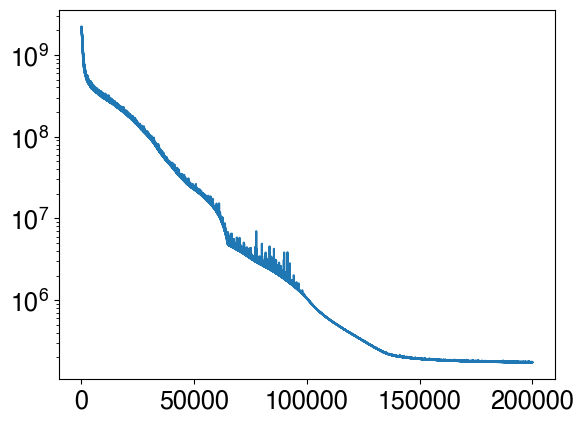

In [111]:
plt.plot(posterior.samples["losses"])
plt.yscale("log")

In [112]:
# Fitting model
#posterior = inference_method.fit(mlr, variant_freqs)
samples = posterior.samples

Text(0, 0.5, 'Growth advantage')

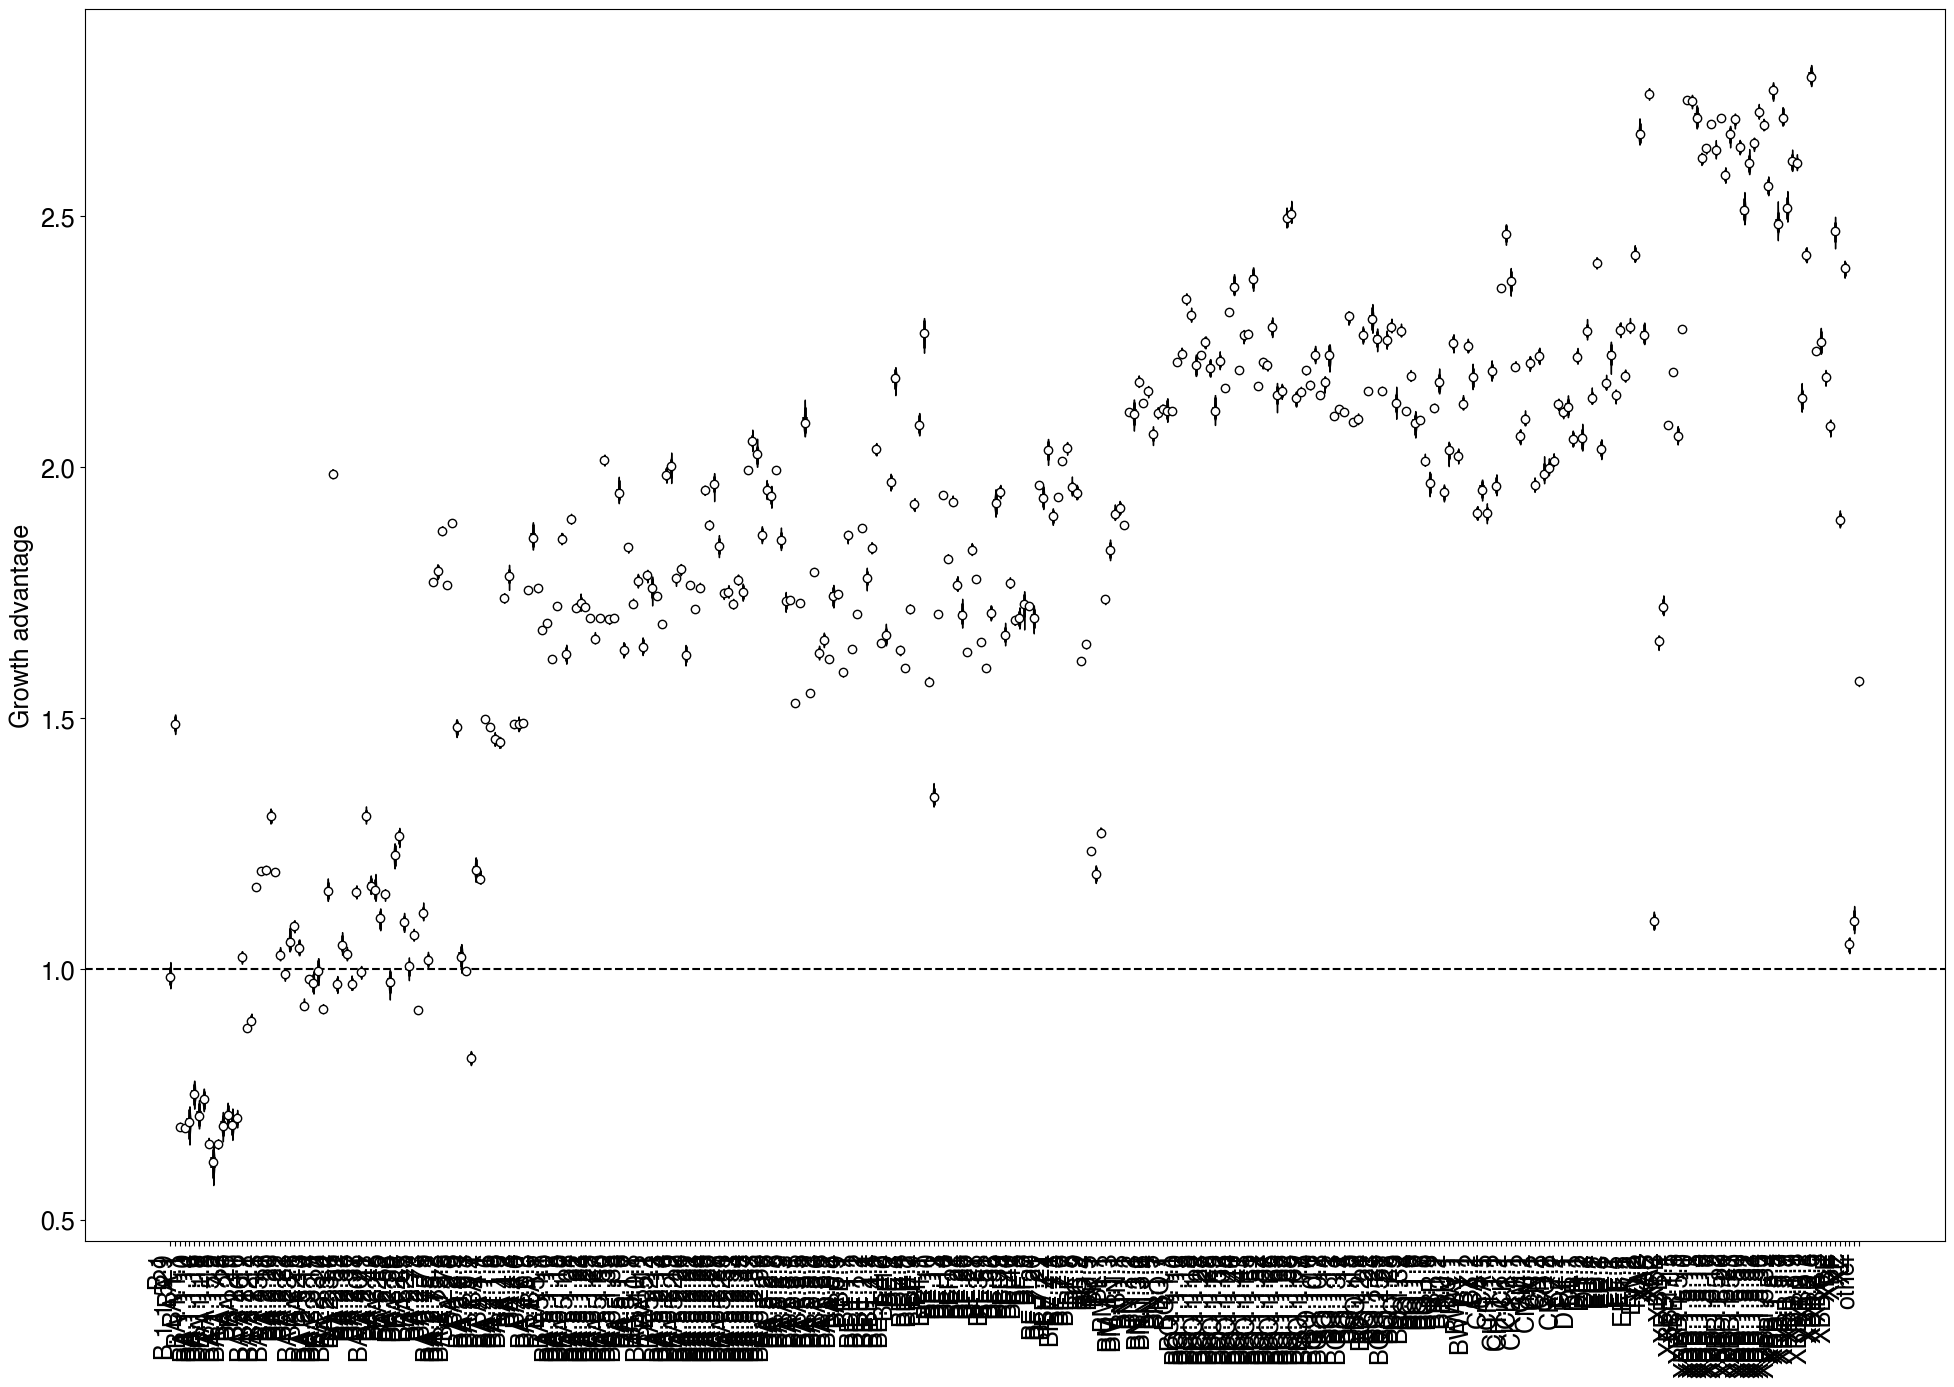

In [113]:
from evofr.plotting import plot_growth_advantage
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

plot_growth_advantage(ax, samples, variant_freqs, [0.8], [0.4], ["grey"] * 400)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
ax.set_ylabel("Growth advantage")

In [114]:
ga_df = pd.DataFrame(ef.posterior.get_growth_advantage(samples, variant_freqs, [0.8], "USA", rel_to="BA.2"))
ga_df

,location,variant,median_ga,ga_upper_80,ga_lower_80
0,USA,B.1,0.9827225,0.99368125,0.971157
1,USA,B.1.1.529,1.4874926,1.4994829,1.4774544
2,USA,BA.1,0.6853554,0.68925333,0.6812461
3,USA,BA.1.1,0.68144405,0.68317336,0.68010056
4,USA,BA.1.1.1,0.69371533,0.71131855,0.67289734
...,...,...,...,...,...
350,USA,XBE,1.8948166,1.903189,1.8866299
351,USA,XBF,2.3956683,2.4040453,2.3878932
352,USA,XE,1.0491562,1.0581981,1.0412639
353,USA,XZ,1.095134,1.1091261,1.085647


In [115]:
def plot_growth_advantage_delta(
    ax, samples, LD, ps, alphas, colors
):
    gad = jnp.array(jnp.exp(samples["delta"]))

    inds = jnp.arange(0, gad.shape[-1], 1)

    ax.axhline(y=1.0, color="k", linestyle="--")
    parts = ax.violinplot(
        gad, inds, showmeans=False, showmedians=False, showextrema=False
    )

    for i, pc in enumerate(parts["bodies"]):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor("black")
        pc.set_alpha(1)

    q1, med, q3 = jnp.percentile(gad, jnp.array([25, 50, 75]), axis=0)
    ax.scatter(inds, med, color="white", zorder=3, edgecolor="black")
    ax.vlines(inds, q1, q3, color="k", lw=4, zorder=2)

    q1, med, q3 = jnp.percentile(gad, jnp.array([2.5, 50, 97.5]), axis=0)
    ax.vlines(inds, q1, q3, color="k", lw=2, zorder=1)

    ax.set_xticks(inds)
    ax.set_xticklabels(LD.var_names)

Text(0, 0.5, 'Growth advantage innovation')

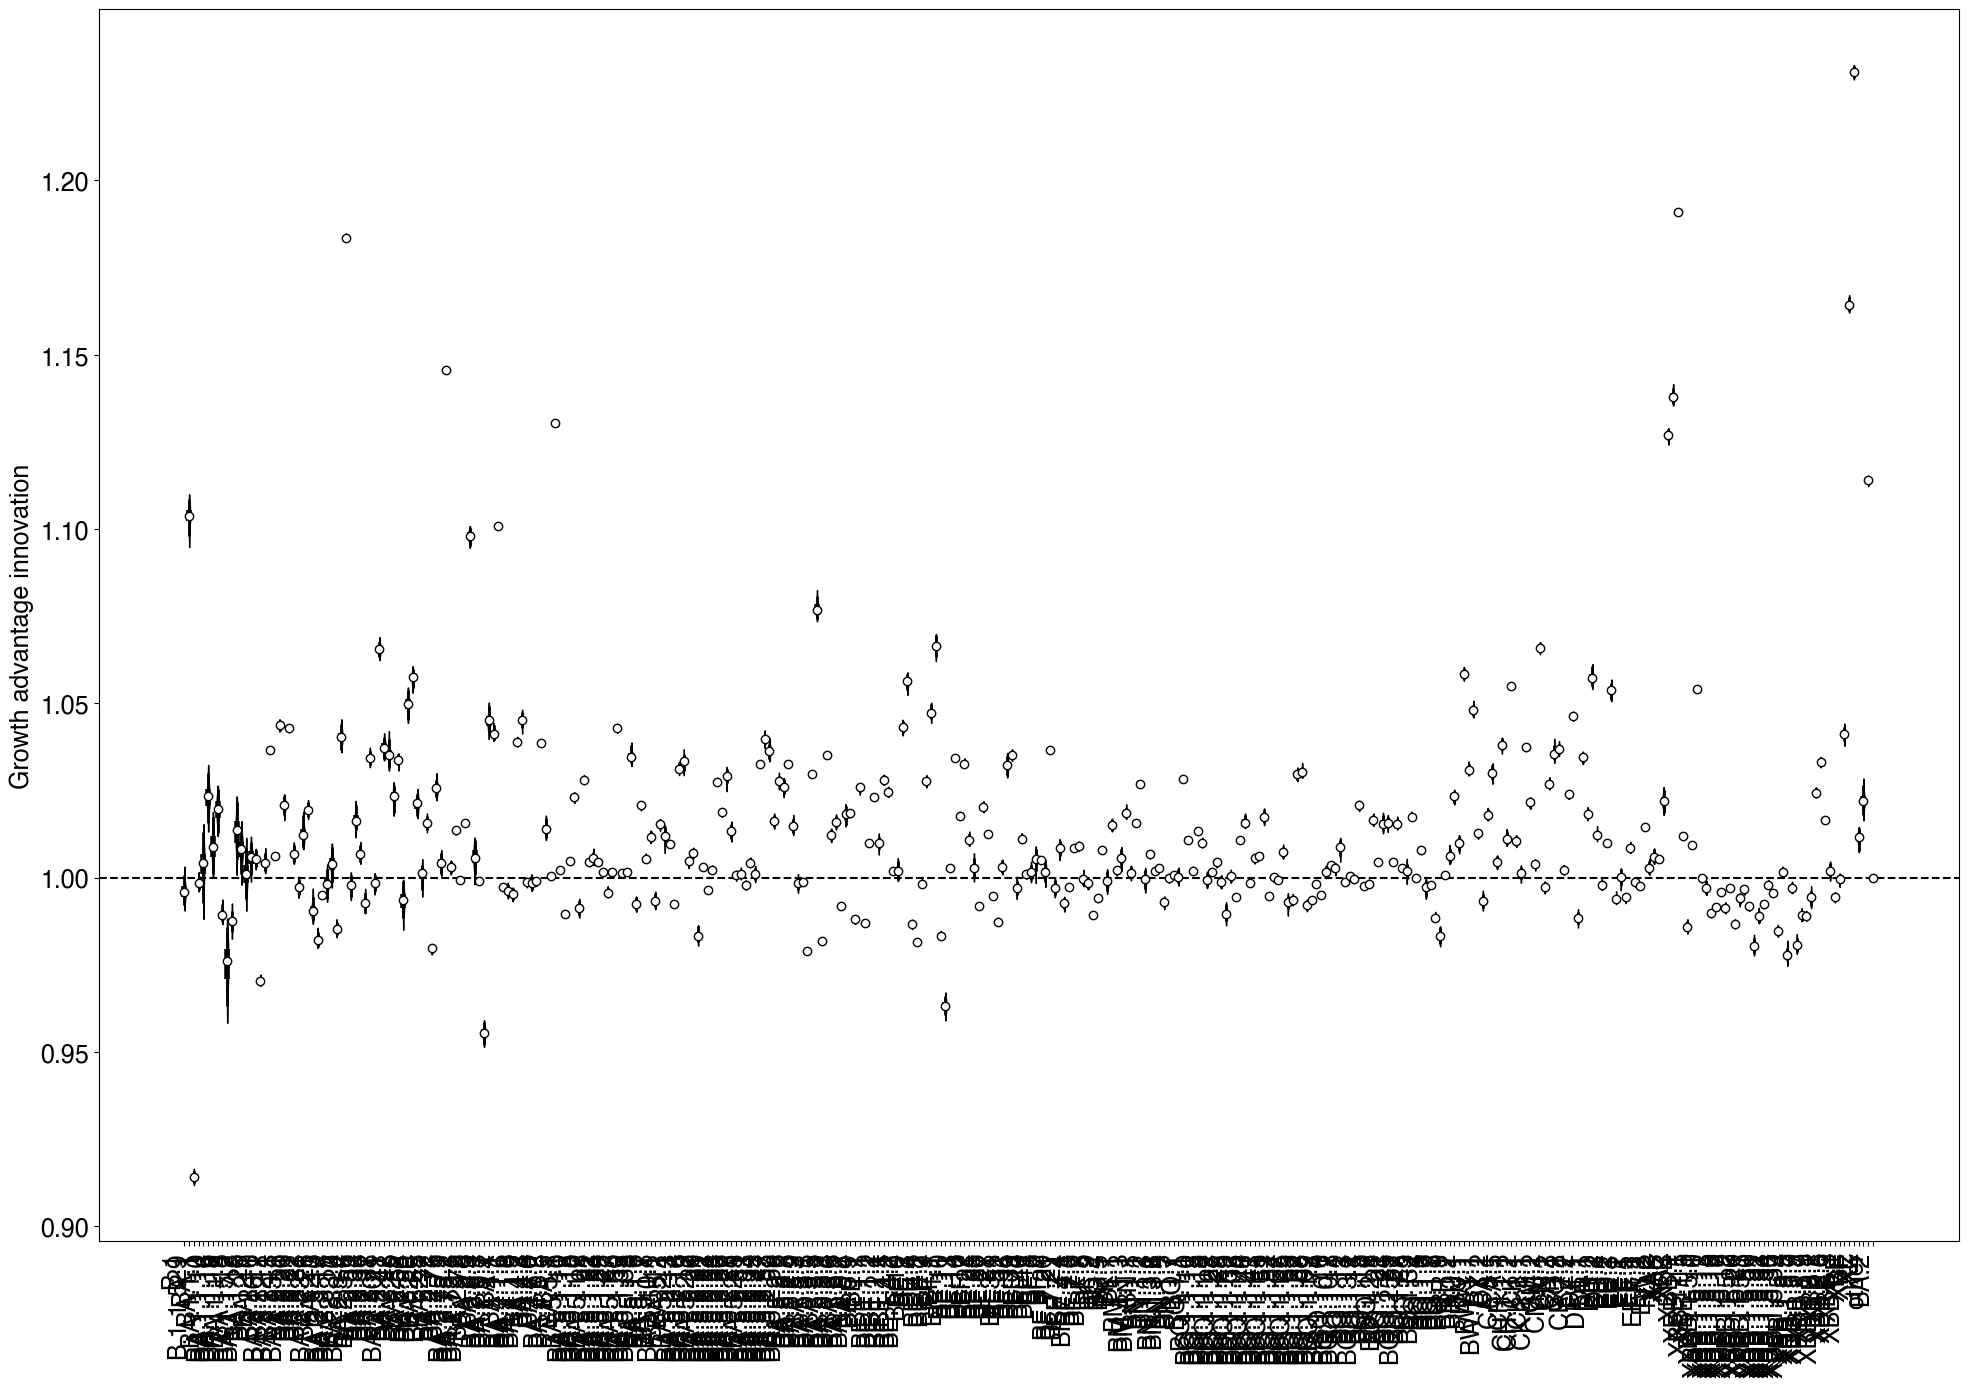

In [116]:
from evofr.plotting import plot_growth_advantage
fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])

plot_growth_advantage_delta(ax, samples, variant_freqs, [0.8], [0.4], ["grey"] * 381)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='right')
ax.set_ylabel("Growth advantage innovation")

In [117]:
def get_growth_advantage_delta(samples, data, ps, name, rel_to="other"):
    # Unpack variant info
    var_names = data.var_names
    par_names = [data.parent_map[v] for v in var_names]

    # Get posterior samples
    ga = jnp.array(jnp.exp(samples["delta"]))
    N_variant = ga.shape[-1]

    # Loop over ga and make relative rel_to
    for i, s in enumerate(var_names):
        if s == rel_to:
            ga = jnp.divide(ga, ga[:, i][:, None])

    #ga = jnp.divide(ga, ga[:, var_names.index(rel_to)][:, None])

    # Compute medians and quantiles
    meds = jnp.median(ga, axis=0)
    gas = []
    for i, p in enumerate(ps):
        up = 0.5 + p / 2
        lp = 0.5 - p / 2
        gas.append(jnp.quantile(ga, jnp.array([lp, up]), axis=0).T)

    # Make empty dictionary
    v_dict = dict()
    v_dict["location"] = []
    v_dict["variant"] = []
    v_dict["parent"] = []
    v_dict["median_ga_delta"] = []

    for p in ps:
        v_dict[f"ga_delta_upper_{round(p * 100)}"] = []
        v_dict[f"ga_delta_lower_{round(p * 100)}"] = []

    for variant in range(N_variant):
        if var_names[variant] != rel_to:
            v_dict["location"].append(name)
            v_dict["variant"].append(var_names[variant])
            v_dict["parent"].append(par_names[variant])
            v_dict["median_ga_delta"].append(meds[variant])
            for i, p in enumerate(ps):
                v_dict[f"ga_delta_upper_{round(p * 100)}"].append(gas[i][variant, 1])
                v_dict[f"ga_delta_lower_{round(p * 100)}"].append(gas[i][variant, 0])

    return v_dict

In [118]:
ga_delta_df = pd.DataFrame(get_growth_advantage_delta(samples, variant_freqs, [0.8], "USA", rel_to="BA.2"))

In [119]:
ga_delta_df

,location,variant,parent,median_ga_delta,ga_delta_upper_80,ga_delta_lower_80
0,USA,B.1,BA.2,0.99585897,0.9984919,0.9930559
1,USA,B.1.1.529,B.1,1.1038628,1.1067171,1.1003467
2,USA,BA.1,BA.2,0.9139708,0.91520584,0.91266304
3,USA,BA.1.1,BA.1,0.9985454,0.99993396,0.99749416
4,USA,BA.1.1.1,BA.1.1,1.0042267,1.0104246,0.9968684
...,...,...,...,...,...,...
350,USA,XBE,BA.2,1.1643604,1.1655833,1.1631607
351,USA,XBF,BA.2,1.2312315,1.2322551,1.2302788
352,USA,XE,BA.2,1.0114908,1.0135597,1.009674
353,USA,XZ,BA.2,1.0218731,1.0249666,1.0197585


Text(0.5, 0, 'log(Growth advantage innovation)')

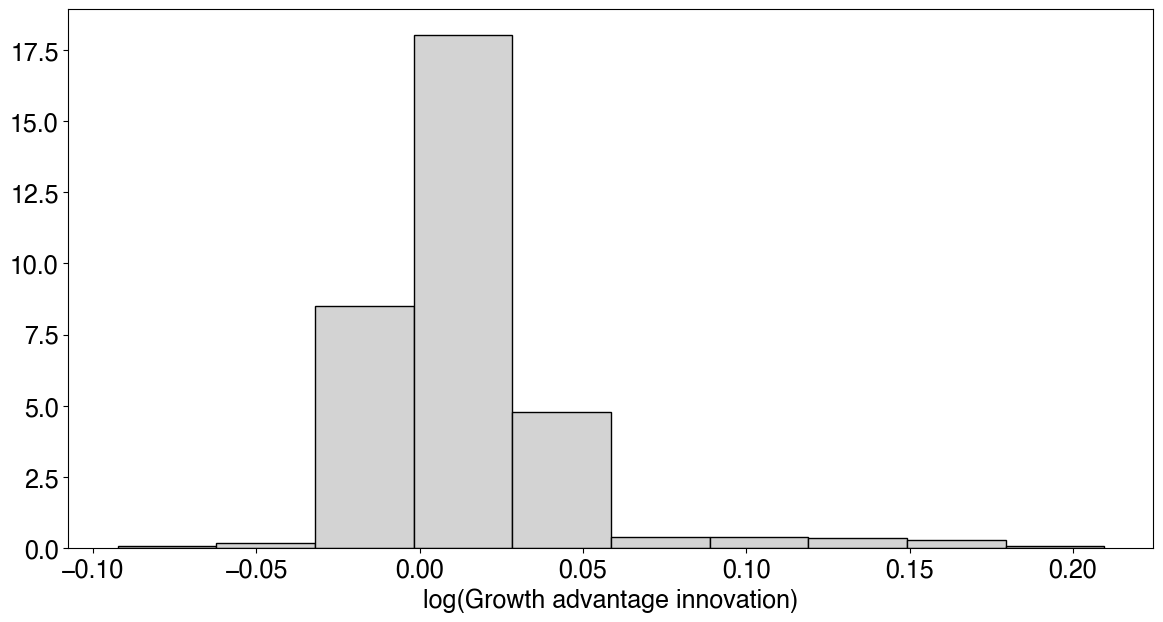

In [120]:
fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0])
ax.hist(samples["delta"].flatten(), ec="k", color="lightgrey", density=True)
ax.set_xlabel("log(Growth advantage innovation)")

In [121]:
def simple_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [122]:
import matplotlib
from matplotlib.cm import coolwarm

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 18}

matplotlib.rc('font', **font)

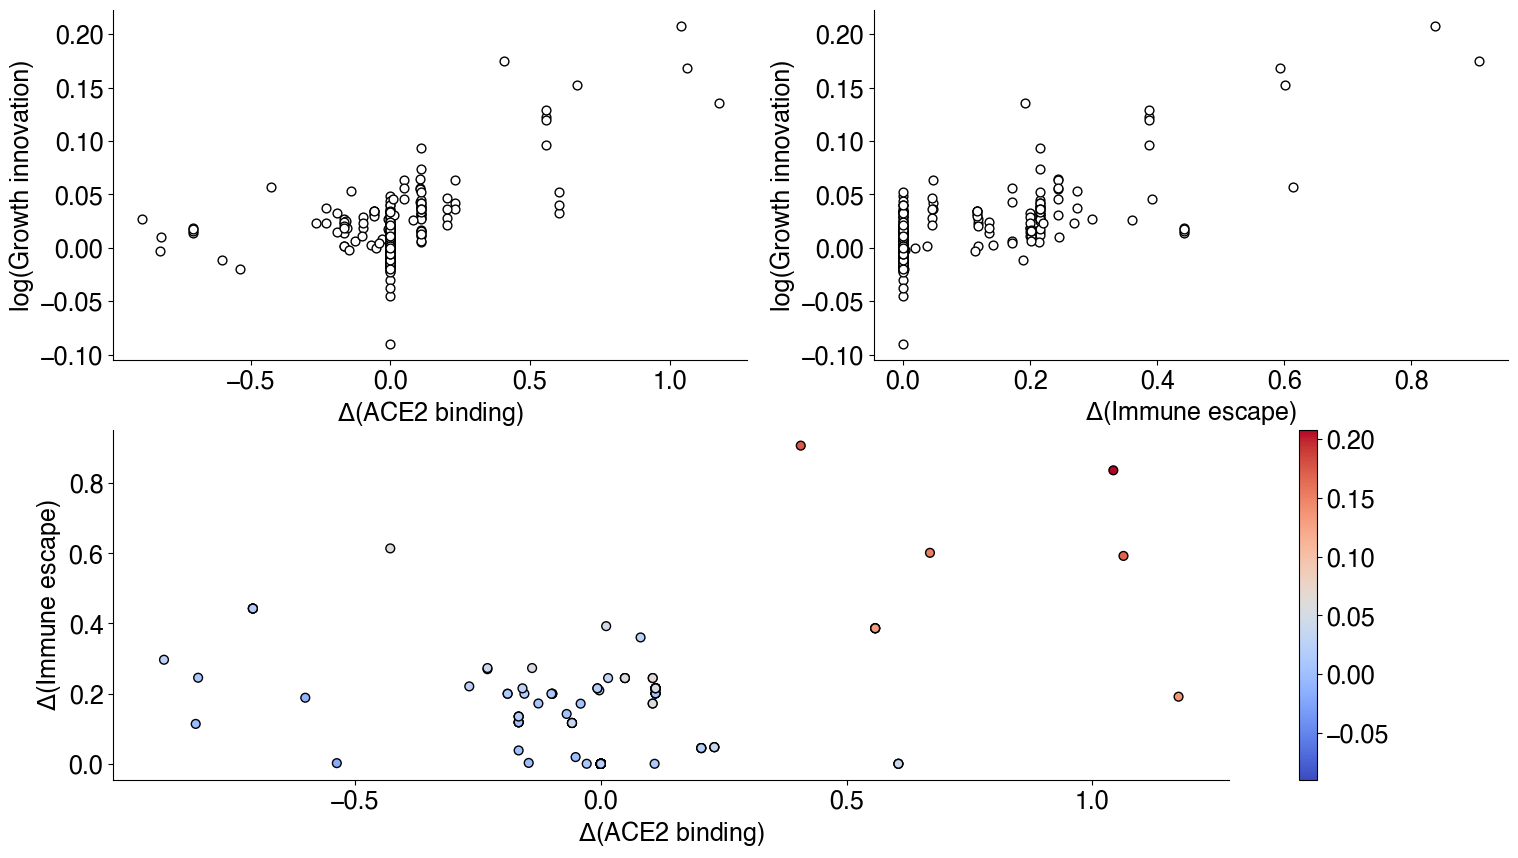

In [123]:
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(nrows=2, ncols=2)

df = escape_scores.reset_index().merge(ga_delta_df, how="left")
log_ga_delta = jnp.log(jnp.hstack(list(df.median_ga_delta.values)))

# Delta ACE2 v. Relative Fitness
ax = fig.add_subplot(gs[0,0]); simple_axis(ax)
ax.scatter(df.delta_ace2_binding,log_ga_delta, ec = "k", color="w", s=40)
ax.set_xlabel(r"$\Delta$(ACE2 binding)")
ax.set_ylabel("log(Growth innovation)")

# Delta Immune escape v. Relative Fitness
ax = fig.add_subplot(gs[0,1]); simple_axis(ax)
ax.scatter(df.delta_immune_escape, log_ga_delta, ec = "k", color="w", s=40)
ax.set_xlabel(r"$\Delta$(Immune escape)")
ax.set_ylabel("log(Growth innovation)")

# Delta ACE2 v. Delta Immune escape
ax = fig.add_subplot(gs[1,:]); simple_axis(ax)
cax = ax.scatter(x=df.delta_ace2_binding, y=df.delta_immune_escape, 
           c=log_ga_delta,
           cmap=coolwarm, ec = "k", s=40)
ax.set_xlabel(r"$\Delta$(ACE2 binding)")
ax.set_ylabel(r"$\Delta$(Immune escape)")

fig.colorbar(cax)

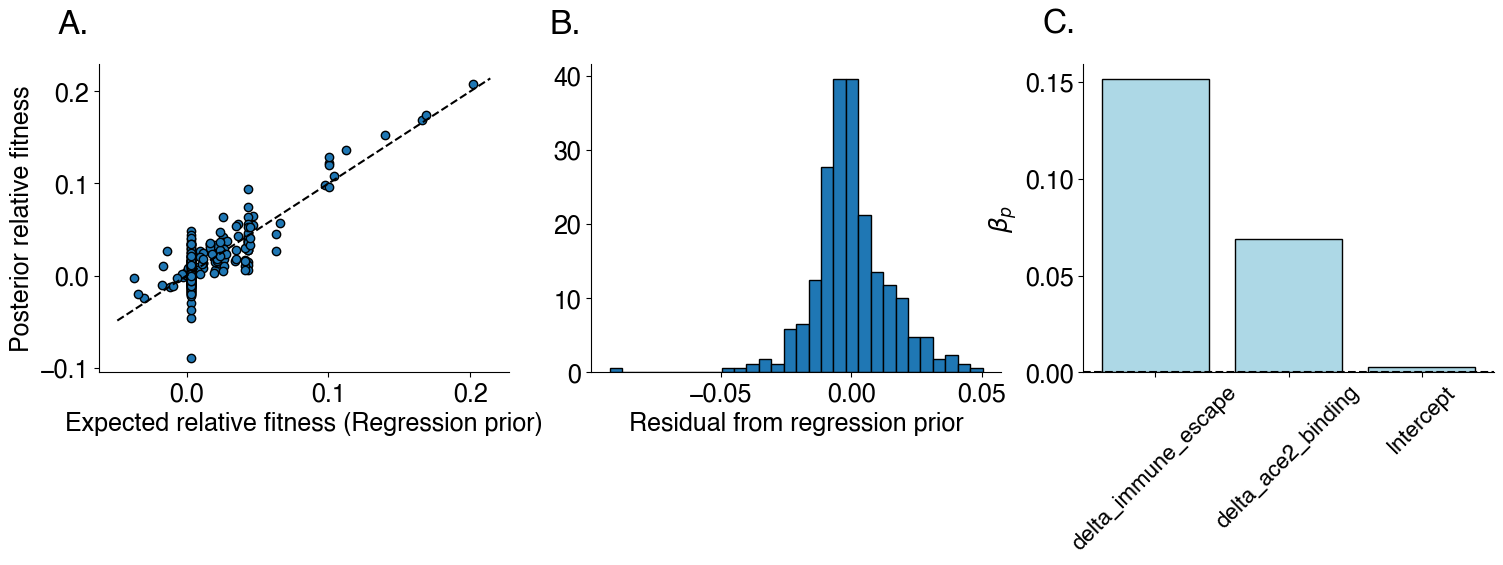

In [128]:
fig = plt.figure(figsize=(18, 4))
gs = fig.add_gridspec(nrows=1, ncols=3)
axes = []

# Comparing regression prior to estimated
ax = fig.add_subplot(gs[0]); simple_axis(ax)
axes.append(ax)

delta_loc_med, delta_loc_quants = ef.get_quantiles(posterior.samples, [0.8], "delta_loc")
raw_delta_med, raw_delta_quants = ef.get_quantiles(posterior.samples, [0.8], "raw_delta")

# TODO: Color points by?
ax.scatter(delta_loc_med, raw_delta_med, ec="k")
#ax.scatter(posterior.samples["delta_loc"], posterior.samples["raw_delta"], alpha=0.01)

def abline(ax, slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color="k")
    
abline(ax, 1.0, 0.0)
ax.set_xlabel("Expected relative fitness (Regression prior)")
ax.set_ylabel("Posterior relative fitness")

# Plotting residuals between estimated relative fitneses and prior expectation
ax = fig.add_subplot(gs[1]); simple_axis(ax)
axes.append(ax)

samples = {"residual_delta": posterior.samples["raw_delta"] - posterior.samples["delta_loc"]}
residual_delta_med, residual_delta_quants = ef.get_quantiles(samples, [0.8], "residual_delta")
ax.hist(residual_delta_med, ec="k", density=True, bins=30)
ax.set_xlabel("Residual from regression prior")


# Plotting coeffiecients for the regression prior
ax_betas = fig.add_subplot(gs[2]); simple_axis(ax_betas)
axes.append(ax_betas)
# TODO: Add uncertainty
theta_med, theta_quants = ef.get_quantiles(posterior.samples, [0.8], "theta")
theta_ind = np.arange(theta_med.shape[0])
ax_betas.bar(theta_ind, theta_med, ec="k", color="lightblue")#, s=80)
ax_betas.axhline(0.0, color="k", linestyle="--")
ax_betas.set_xticks(theta_ind)
ax_betas.set_xticklabels([  f"{name}" for name in predictor_names + ["Intercept"]], size=16, rotation=45)
ax_betas.set_ylabel(r"$\beta_{p}$")

for ax, ax_label in zip(axes, ['A.', 'B.', 'C.']):
    ax.text(-0.1, 1.1, ax_label, transform=ax.transAxes, size=24, weight='bold')
